<a href="https://colab.research.google.com/github/rulas99/INAH_webmap/blob/main/InferData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt

from pandas import read_csv

In [2]:
imagePath = read_csv('/content/drive/MyDrive/Inge/segment_sentinel2_hotspot/test_2.csv') # Test image
test_paths = list(imagePath.ori_path)
test_paths_a = list(imagePath.label_path)

In [11]:
modelPath = "/content/drive/MyDrive/Inge/segment_sentinel2_hotspot/Models_2/model_598_v2.torch"  # Path to trained model
height=width=500

In [12]:
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),])

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net = Net.to(device) # Set net to GPU or CPU

Net.load_state_dict(torch.load(modelPath, map_location=torch.device('cpu'))) # Load trained model
Net.eval() # Set to evaluation mode

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

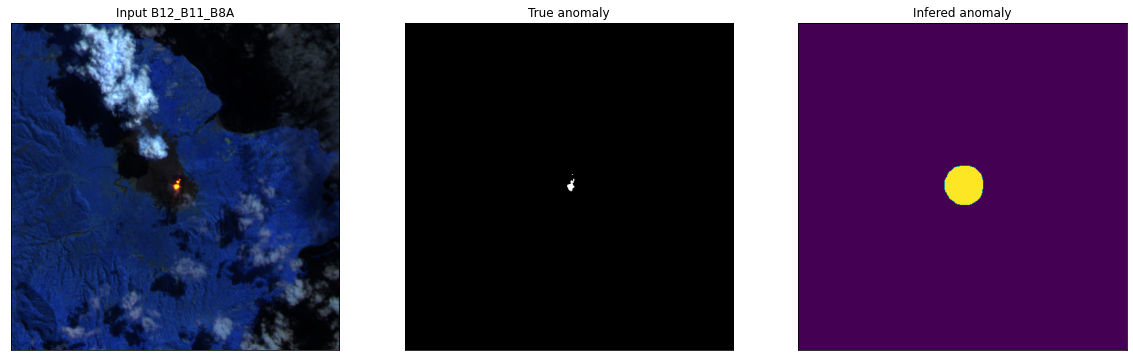

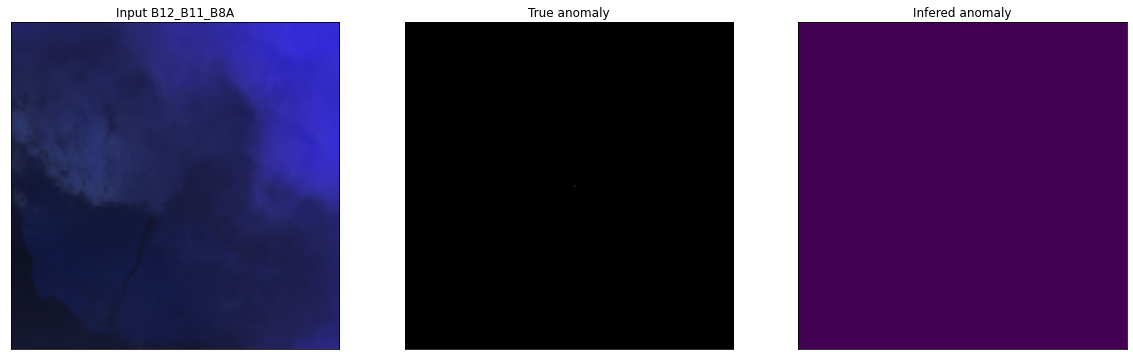

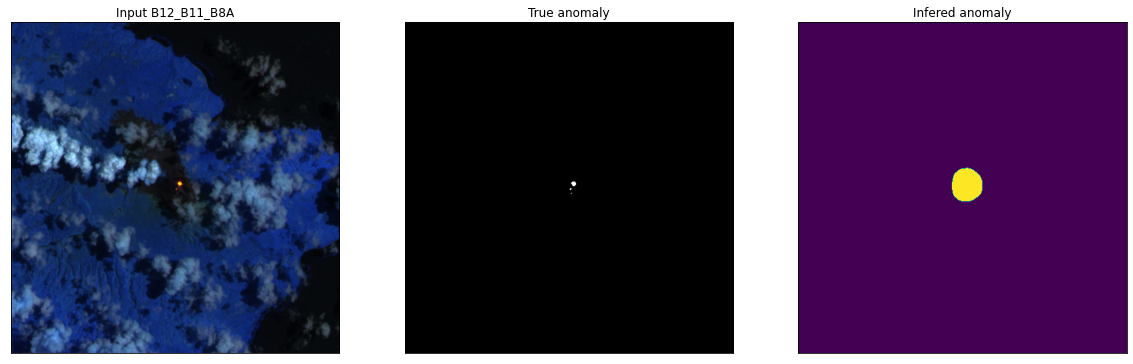

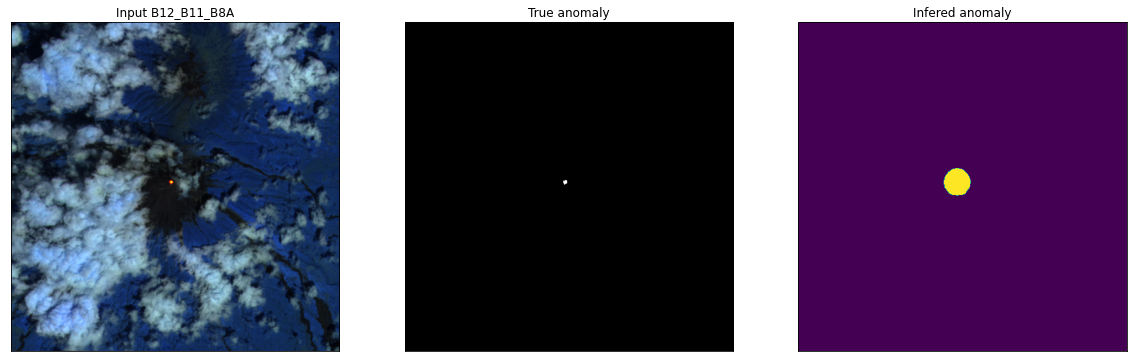

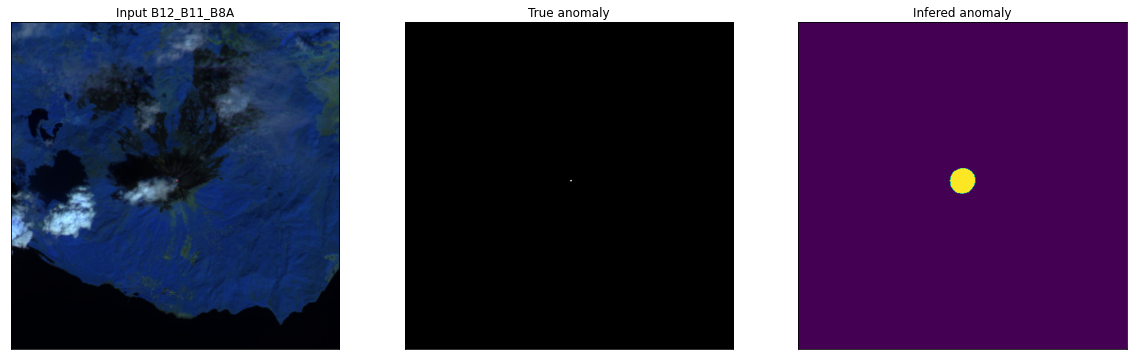

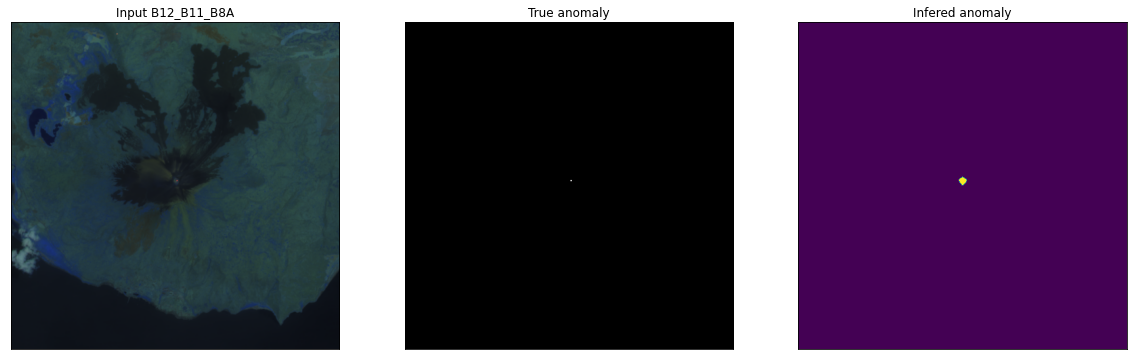

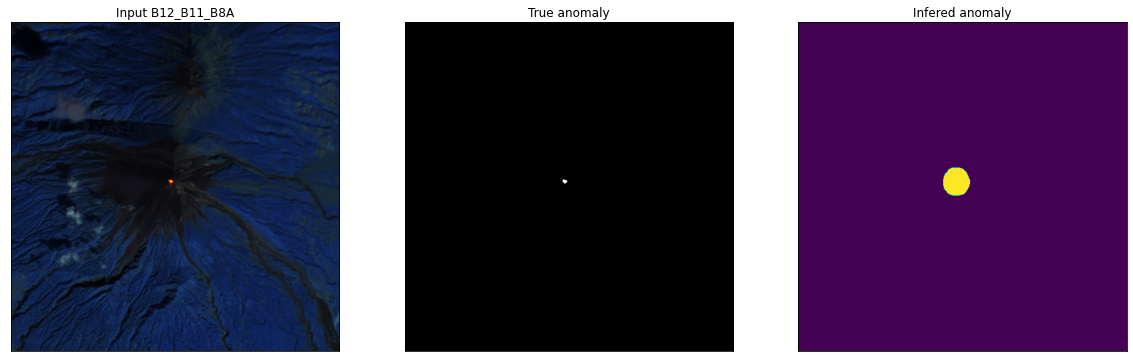

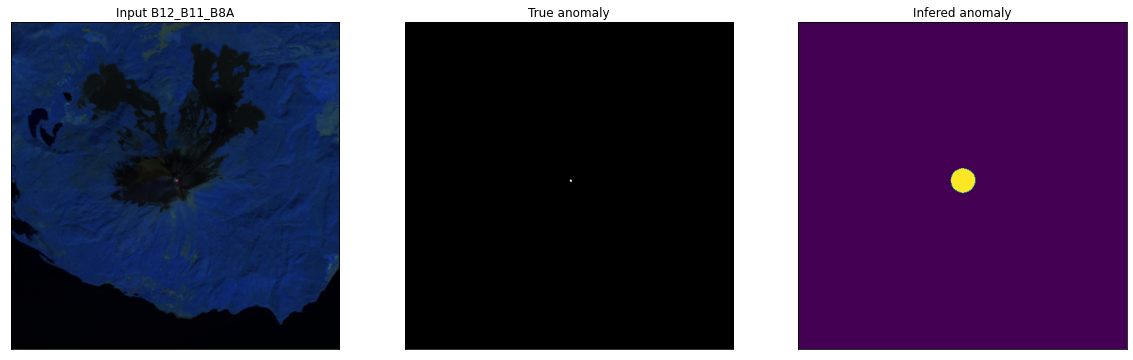

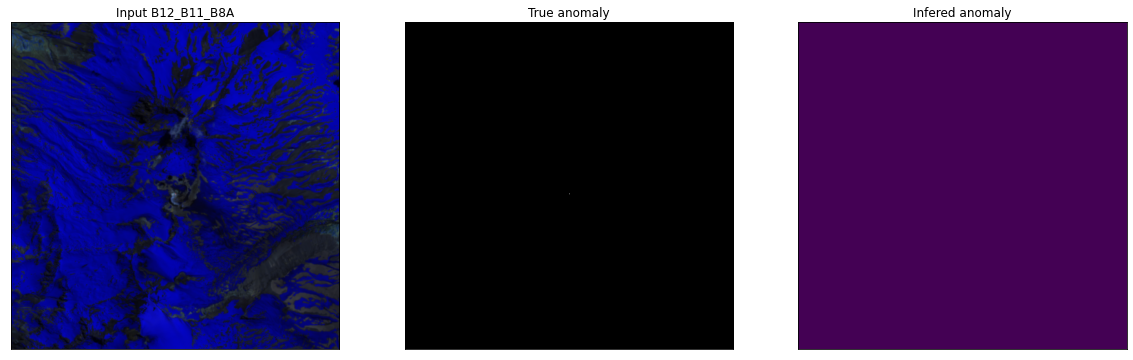

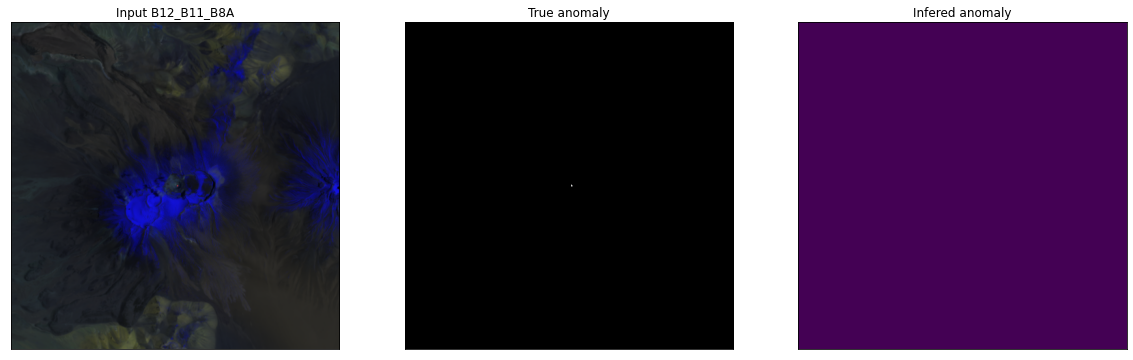

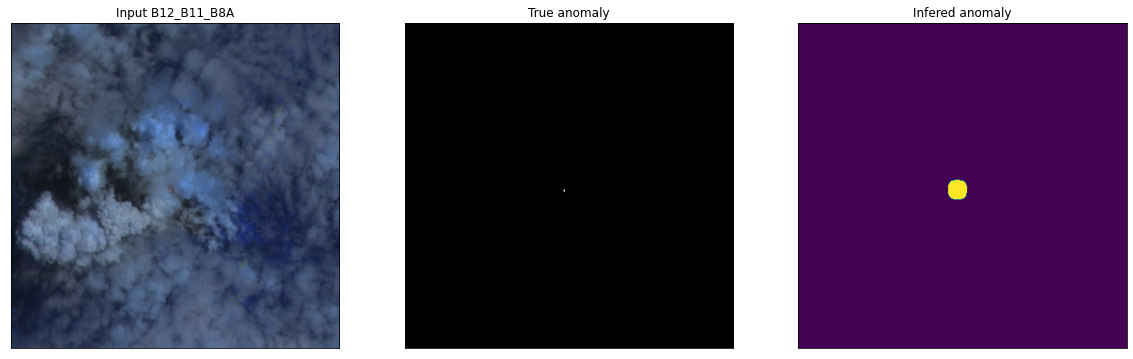

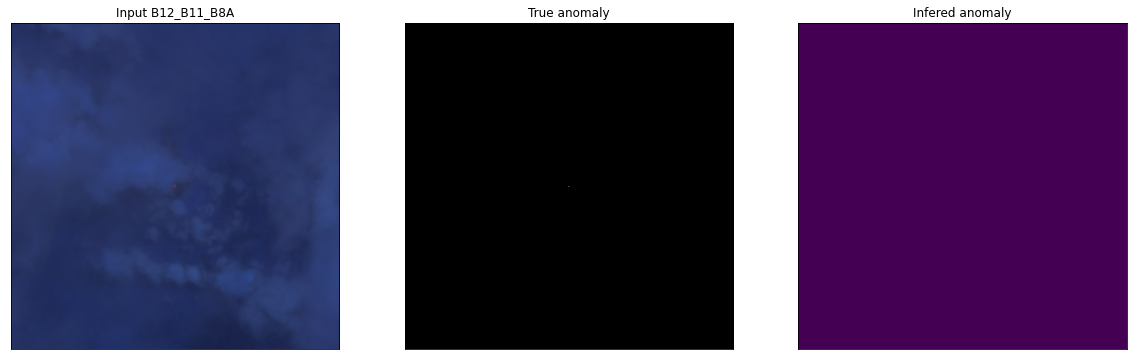

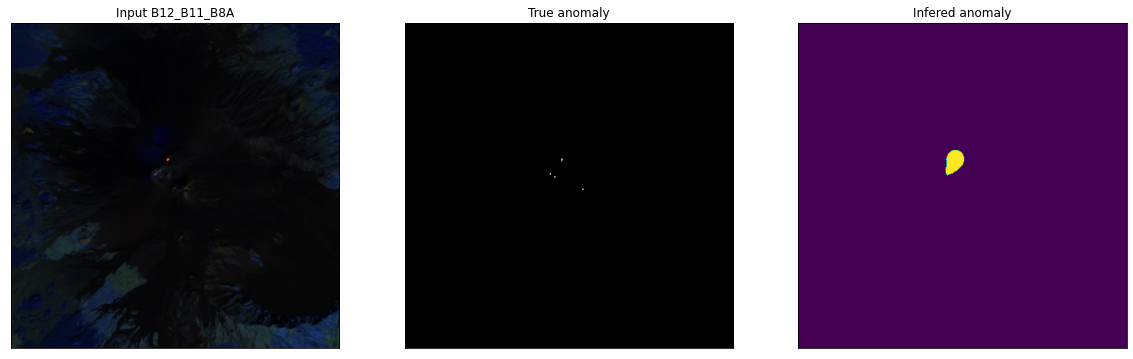

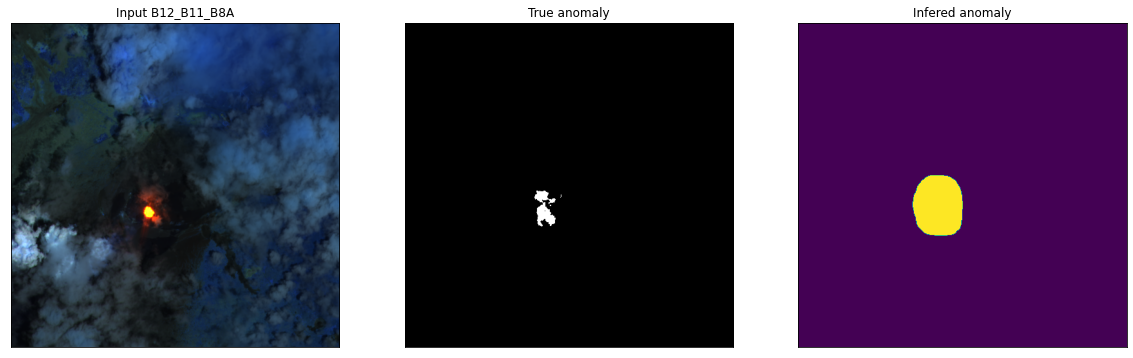

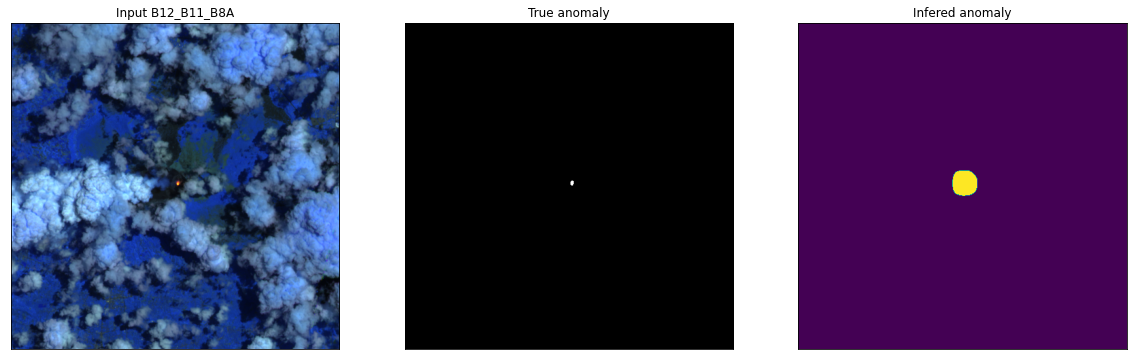

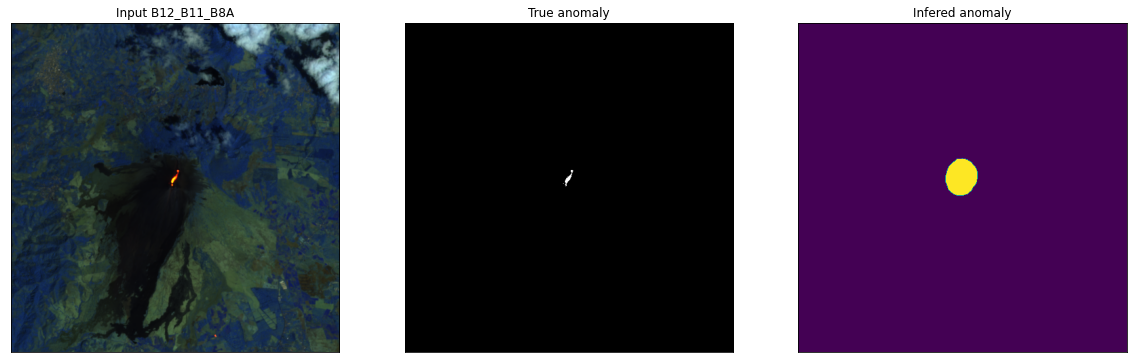

In [14]:
for i,j in zip(test_paths,test_paths_a):

  plt.figure(figsize=(20,13))

  plt.subplot(1, 3, 1, title='Input B12_B11_B8A', xticks=[], yticks=[])
  Img = cv2.imread(i) # load test image
  height_orgin , widh_orgin ,d = Img.shape # Get image original size 
  plt.imshow(Img[:,:,::-1])  # Show image

  plt.subplot(1, 3, 2, title='True anomaly', xticks=[], yticks=[])
  ann = cv2.imread(j) # load real label image
  plt.imshow(ann[:,:,::-1])

  plt.subplot(1, 3, 3, title='Infered anomaly', xticks=[], yticks=[])
  Img = transformImg(Img)  # Transform to pytorch
  Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
  with torch.no_grad():
      Prd = Net(Img)['out']  # Run net
  Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
  seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
  plt.imshow(seg)  # display image

  plt.show()